<a href="https://colab.research.google.com/github/Jundo22l/CAU_internship/blob/main/U_NET(0926).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. 환경 설정 및 라이브러리 설치**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import vgg16
import torchvision.transforms.functional as TVF
import glob

# For reproducibility
import torch.cuda.amp as amp
import warnings
warnings.filterwarnings("ignore")

# CUDA synchronous error reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Download and extract Pascal VOC 2012 dataset if not already present
if not os.path.exists("VOCdevkit"):
    !wget -q http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
    !tar -xf VOCtrainval_11-May-2012.tar

**2. Pascal VOC 데이터셋 클래스 정의**

In [13]:
# COLOR_2_INDEX and CLASS_NAMES definitions for Pascal VOC 2012
COLOR_2_INDEX = {
    (0, 0, 0): 0,            # Background
    (128, 0, 0): 1,          # Aeroplane
    (0, 128, 0): 2,          # Bicycle
    (128, 128, 0): 3,        # Bird
    (0, 0, 128): 4,          # Boat
    (128, 0, 128): 5,        # Bottle
    (0, 128, 128): 6,        # Bus
    (128, 128, 128): 7,      # Car
    (64, 0, 0): 8,           # Cat
    (192, 0, 0): 9,          # Chair
    (64, 128, 0): 10,        # Cow
    (192, 128, 0): 11,       # Dining Table
    (64, 0, 128): 12,        # Dog
    (192, 0, 128): 13,       # Horse
    (64, 128, 128): 14,      # Motorbike
    (192, 128, 128): 15,     # Person
    (0, 64, 0): 16,          # Potted Plant
    (128, 64, 0): 17,        # Sheep
    (0, 192, 0): 18,         # Sofa
    (128, 192, 0): 19,       # Train
    (0, 64, 128): 20         # TV/Monitor
}
CLASS_NAMES = [
    "Background", "Aeroplane", "Bicycle", "Bird", "Boat", "Bottle", "Bus", "Car",
    "Cat", "Chair", "Cow", "Dining Table", "Dog", "Horse", "Motorbike",
    "Person", "Potted Plant", "Sheep", "Sofa", "Train", "TV/Monitor"
]

class PascalVoc(Dataset):
    def __init__(self, segmentation_imgs, img_size=224, device="cuda"):
        self.seg_folder = "SegmentationClass/"
        self.img_folder = "JPEGImages/"
        self.segmentation_imgs = segmentation_imgs
        self.img_size = img_size
        self.device = device

    def __len__(self):
        return len(self.segmentation_imgs)

    def get_paths(self, idx):
        mask_path = self.segmentation_imgs[idx]
        file_name = os.path.basename(mask_path)
        img_name = os.path.splitext(file_name)[0] + ".jpg"
        img_path = os.path.join("VOCdevkit/VOC2012/", "JPEGImages", img_name)
        return img_path, mask_path

    def load_imgs(self, idx):
        img_path, mask_path = self.get_paths(idx)
        img = Image.open(img_path).convert("RGB").resize((self.img_size, self.img_size))
        mask_img = Image.open(mask_path).convert("RGB").resize((self.img_size, self.img_size))
        return img, mask_img

    @staticmethod
    def create_label_mask(mask_img):
        mask = np.array(mask_img).astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for color, idx in COLOR_2_INDEX.items():
            label_mask[np.all(mask == color, axis=-1)] = idx
        return label_mask

    def __getitem__(self, idx):
        img, mask_img = self.load_imgs(idx)
        mask_img = PascalVoc.create_label_mask(mask_img)
        mask_img = torch.from_numpy(mask_img).long()
        img = TVF.to_tensor(img)
        img = TVF.normalize(img,
                            mean=(0.485, 0.456, 0.406),
                            std=(0.229, 0.224, 0.225))
        return img, mask_img

**3. 데이터셋 분할**

In [14]:
all_segmentation_imgs = glob.glob(os.path.join("VOCdevkit/VOC2012/", "SegmentationClass", "*"))

random.shuffle(all_segmentation_imgs)

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

total = len(all_segmentation_imgs)
train_end = int(train_ratio * total)
val_end = train_end + int(val_ratio * total)

train_imgs = all_segmentation_imgs[:train_end]
val_imgs = all_segmentation_imgs[train_end:val_end]
test_imgs = all_segmentation_imgs[val_end:]

print(f"Total images: {total}")
print(f"Training images: {len(train_imgs)}")
print(f"Validation images: {len(val_imgs)}")
print(f"Test images: {len(test_imgs)}")

Total images: 2913
Training images: 2330
Validation images: 291
Test images: 292


**4. U-Net 모델 정의**

In [15]:
class conv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.bn(x)
        return x

class trans_conv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels,
                                       kernel_size=3, stride=2,
                                       padding=1, output_padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.bn(x)
        return x

class u_net(nn.Module):
    def __init__(self, num_classes, device="cuda"):
        super().__init__()
        self.num_classes = num_classes
        self.device = device
        self.un_block_indices = [(0, 4), (5, 9), (10, 16),
                                 (17, 23), (24, 30)]

        self.init_vgg()

        self.conv_7x7_1 = conv2d(512, 512)
        self.conv_7x7_2 = conv2d(512, 512)

        self.trans_conv_1 = trans_conv2d(512, 256)
        self.trans_conv_2 = trans_conv2d(512, 256)
        self.trans_conv_3 = trans_conv2d(512, 128)
        self.trans_conv_4 = trans_conv2d(256, 64)
        self.trans_conv_5 = trans_conv2d(128, 32)

        self.conv_1 = conv2d(256 + 512, 512)
        self.conv_2 = conv2d(256 + 512, 512)
        self.conv_3 = conv2d(128 + 256, 256)
        self.conv_4 = conv2d(64 + 128, 128)
        self.out_conv = nn.Conv2d(32 + 64, num_classes, stride=1, kernel_size=1)

    def init_vgg(self):
        model = vgg16(pretrained=True)
        del model.classifier
        model = model.to(self.device)

        self.blocks = nn.ModuleList()

        for block_idx in self.un_block_indices:
            self.blocks.append(nn.Sequential(*model.features[block_idx[0]:block_idx[1]]))

        for block in self.blocks:
            for param in block.parameters():
                param.requires_grad = False  # Freeze encoder

    def forward(self, x):
        x_1 = self.blocks[0](x)
        encoder = F.max_pool2d(x_1, kernel_size=2, stride=2)
        x_2 = self.blocks[1](encoder)
        encoder = F.max_pool2d(x_2, kernel_size=2, stride=2)
        x_3 = self.blocks[2](encoder)
        encoder = F.max_pool2d(x_3, kernel_size=2, stride=2)
        x_4 = self.blocks[3](encoder)
        encoder = F.max_pool2d(x_4, kernel_size=2, stride=2)
        x_5 = self.blocks[4](encoder)
        encoder = F.max_pool2d(x_5, kernel_size=2, stride=2)

        encoder = self.conv_7x7_1(encoder)
        encoder = self.conv_7x7_2(encoder)

        decoder = self.trans_conv_1(encoder)
        decoder = torch.cat((decoder, x_5), dim=1)
        decoder = self.conv_1(decoder)

        decoder = self.trans_conv_2(decoder)
        decoder = torch.cat((decoder, x_4), dim=1)
        decoder = self.conv_2(decoder)

        decoder = self.trans_conv_3(decoder)
        decoder = torch.cat((decoder, x_3), dim=1)
        decoder = self.conv_3(decoder)

        decoder = self.trans_conv_4(decoder)
        decoder = torch.cat((decoder, x_2), dim=1)
        decoder = self.conv_4(decoder)

        decoder = self.trans_conv_5(decoder)
        decoder = torch.cat((decoder, x_1), dim=1)
        decoder = self.out_conv(decoder)

        score = F.log_softmax(decoder, dim=1)
        return score

**5. 모델 트레이닝 정의 & Evaluate 함수 정의**

In [16]:
def calculate_iou(preds, labels, num_classes):
    ious = []
    preds = preds.view(-1)
    labels = labels.view(-1)
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds[target_inds]).long().sum().item()
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(float(intersection) / float(max(union, 1)))
    ious = [iou for iou in ious if not np.isnan(iou)]
    if len(ious) == 0:
        return 0
    return np.mean(ious)

def train_model(model,
                train_loader, val_loader,
                criterion, optimizer,
                scheduler, grad_scaler,
                num_epochs=30, device="cuda"):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_iou': [],
        'val_iou': []
    }

    best_iou = -1
    best_model_state = None

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0
        train_iou = 0.0

        for batch_idx, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            with amp.autocast(enabled=True):
                y_hat = model(x)
                loss = criterion(y_hat, y)
            grad_scaler.scale(loss).backward()
            grad_scaler.step(optimizer)
            grad_scaler.update()

            train_loss += loss.item()

            preds = torch.argmax(y_hat, dim=1)
            train_iou += calculate_iou(preds, y, model.num_classes)

        avg_train_loss = train_loss / len(train_loader)
        avg_train_iou = train_iou / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_hat_val = model(x_val)
                loss_val = criterion(y_hat_val, y_val)
                val_loss += loss_val.item()

                preds_val = torch.argmax(y_hat_val, dim=1)
                val_iou += calculate_iou(preds_val, y_val, model.num_classes)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)

        # Scheduler step based on validation IoU
        scheduler.step(avg_val_iou)

        # Record history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_iou'].append(avg_train_iou)
        history['val_iou'].append(avg_val_iou)

        print(f"-------Epoch {epoch}-------")
        print(f"Train Loss: {avg_train_loss:.4f} | Train IoU: {avg_train_iou:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f} | Val IoU: {avg_val_iou:.4f}")

        if avg_val_iou > best_iou:
            best_iou = avg_val_iou
            best_model_state = model.state_dict()

    return history, best_model_state

**6. 모델 학습 및 옵티마이저 비교**

In [18]:
# create_color_map 함수 정의
def create_color_map(num_classes):
    """
    세그멘테이션 마스크 시각화를 위한 색상 맵을 생성합니다.
    """
    np.random.seed(0)
    color_map = {}
    for i in range(num_classes):
        color_map[i] = np.random.randint(0, 256, size=(3,)).tolist()
    return color_map

# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize datasets
train_dataset = PascalVoc(train_imgs, img_size=224, device=device)
val_dataset = PascalVoc(val_imgs, img_size=224, device=device)
test_dataset = PascalVoc(test_imgs, img_size=224, device=device)

# Initialize DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

# Define color map for visualization
color_map = create_color_map(num_classes=len(CLASS_NAMES))

# Define number of classes
num_classes = len(CLASS_NAMES)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer parameters (common for all optimizers)
optimizer_params = {
    'lr': 2e-3,
    'weight_decay': 1e-5
}

# Initialize GradScaler for mixed precision
grad_scaler = amp.GradScaler(enabled=True)

# Define number of epochs
num_epochs = 30

# Define optimizers to compare
optimizers = ['SGD', 'Adam', 'AdamW']

# Store histories and best models
all_histories = {}
best_models = {}

for opt_name in optimizers:
    print(f"\nTraining with optimizer: {opt_name}\n{'='*40}")
    # Re-initialize the model for each optimizer to ensure fair comparison
    model = u_net(num_classes=num_classes, device=device).to(device)

    # Define separate optimizer-specific parameters if needed
    if opt_name == 'SGD':
        optimizer_specific_params = {
            'momentum': 0.9,
            'nesterov': True
        }
    elif opt_name == 'Adam':
        optimizer_specific_params = {
            'betas': (0.9, 0.999)
        }
    elif opt_name == 'AdamW':
        optimizer_specific_params = {
            'betas': (0.9, 0.999),
            'eps': 1e-08
        }

    # Merge common and optimizer-specific parameters
    current_optimizer_params = {**optimizer_params, **optimizer_specific_params}

    # Initialize optimizer
    if opt_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), **current_optimizer_params)
    elif opt_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), **current_optimizer_params)
    elif opt_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), **current_optimizer_params)

    # Initialize learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, verbose=True)

    # Re-initialize GradScaler for each optimizer
    grad_scaler = amp.GradScaler(enabled=True)

    # Train the model
    history, best_model_state = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        grad_scaler=grad_scaler,
        num_epochs=num_epochs,
        device=device
    )

    # Save history and best model
    all_histories[opt_name] = history
    best_models[opt_name] = best_model_state

    print(f"Finished training with optimizer: {opt_name}")


Training with optimizer: SGD


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 224MB/s]


-------Epoch 1-------
Train Loss: 1.6330 | Train IoU: 0.0346
Val Loss: 1.1567 | Val IoU: 0.0391
-------Epoch 2-------
Train Loss: 1.2030 | Train IoU: 0.0390
Val Loss: 1.0556 | Val IoU: 0.0412
-------Epoch 3-------
Train Loss: 1.1245 | Train IoU: 0.0419
Val Loss: 0.9940 | Val IoU: 0.0451
-------Epoch 4-------
Train Loss: 1.0673 | Train IoU: 0.0456
Val Loss: 0.9469 | Val IoU: 0.0497
-------Epoch 5-------
Train Loss: 1.0186 | Train IoU: 0.0493
Val Loss: 0.9029 | Val IoU: 0.0547
-------Epoch 6-------
Train Loss: 0.9715 | Train IoU: 0.0557
Val Loss: 0.8605 | Val IoU: 0.0614
-------Epoch 7-------
Train Loss: 0.9321 | Train IoU: 0.0619
Val Loss: 0.8303 | Val IoU: 0.0681
-------Epoch 8-------
Train Loss: 0.8988 | Train IoU: 0.0664
Val Loss: 0.8034 | Val IoU: 0.0707
-------Epoch 9-------
Train Loss: 0.8729 | Train IoU: 0.0710
Val Loss: 0.7802 | Val IoU: 0.0758
-------Epoch 10-------
Train Loss: 0.8489 | Train IoU: 0.0747
Val Loss: 0.7599 | Val IoU: 0.0789
-------Epoch 11-------
Train Loss: 0.82

**7. 학습 결과 및 시각화 결과**

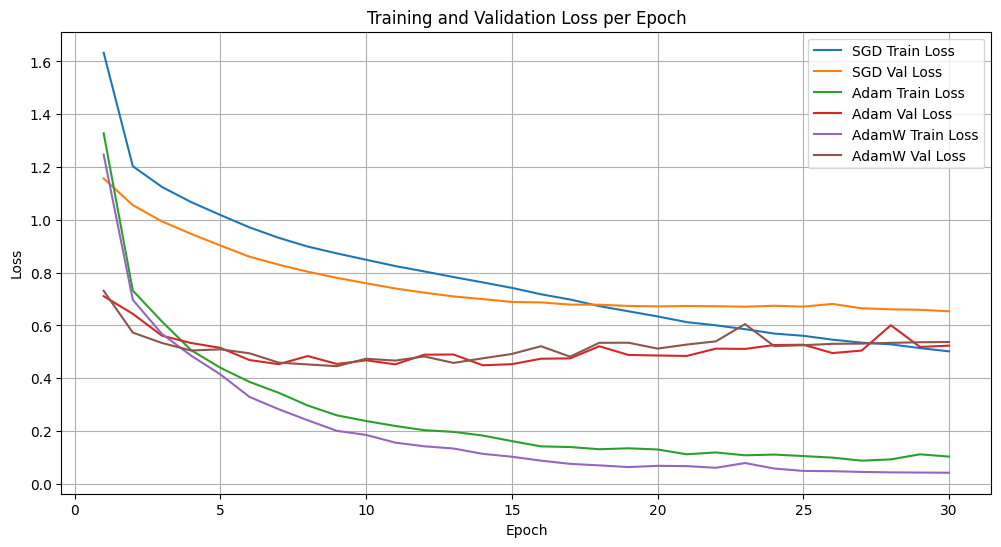


Evaluating best model from optimizer: SGD


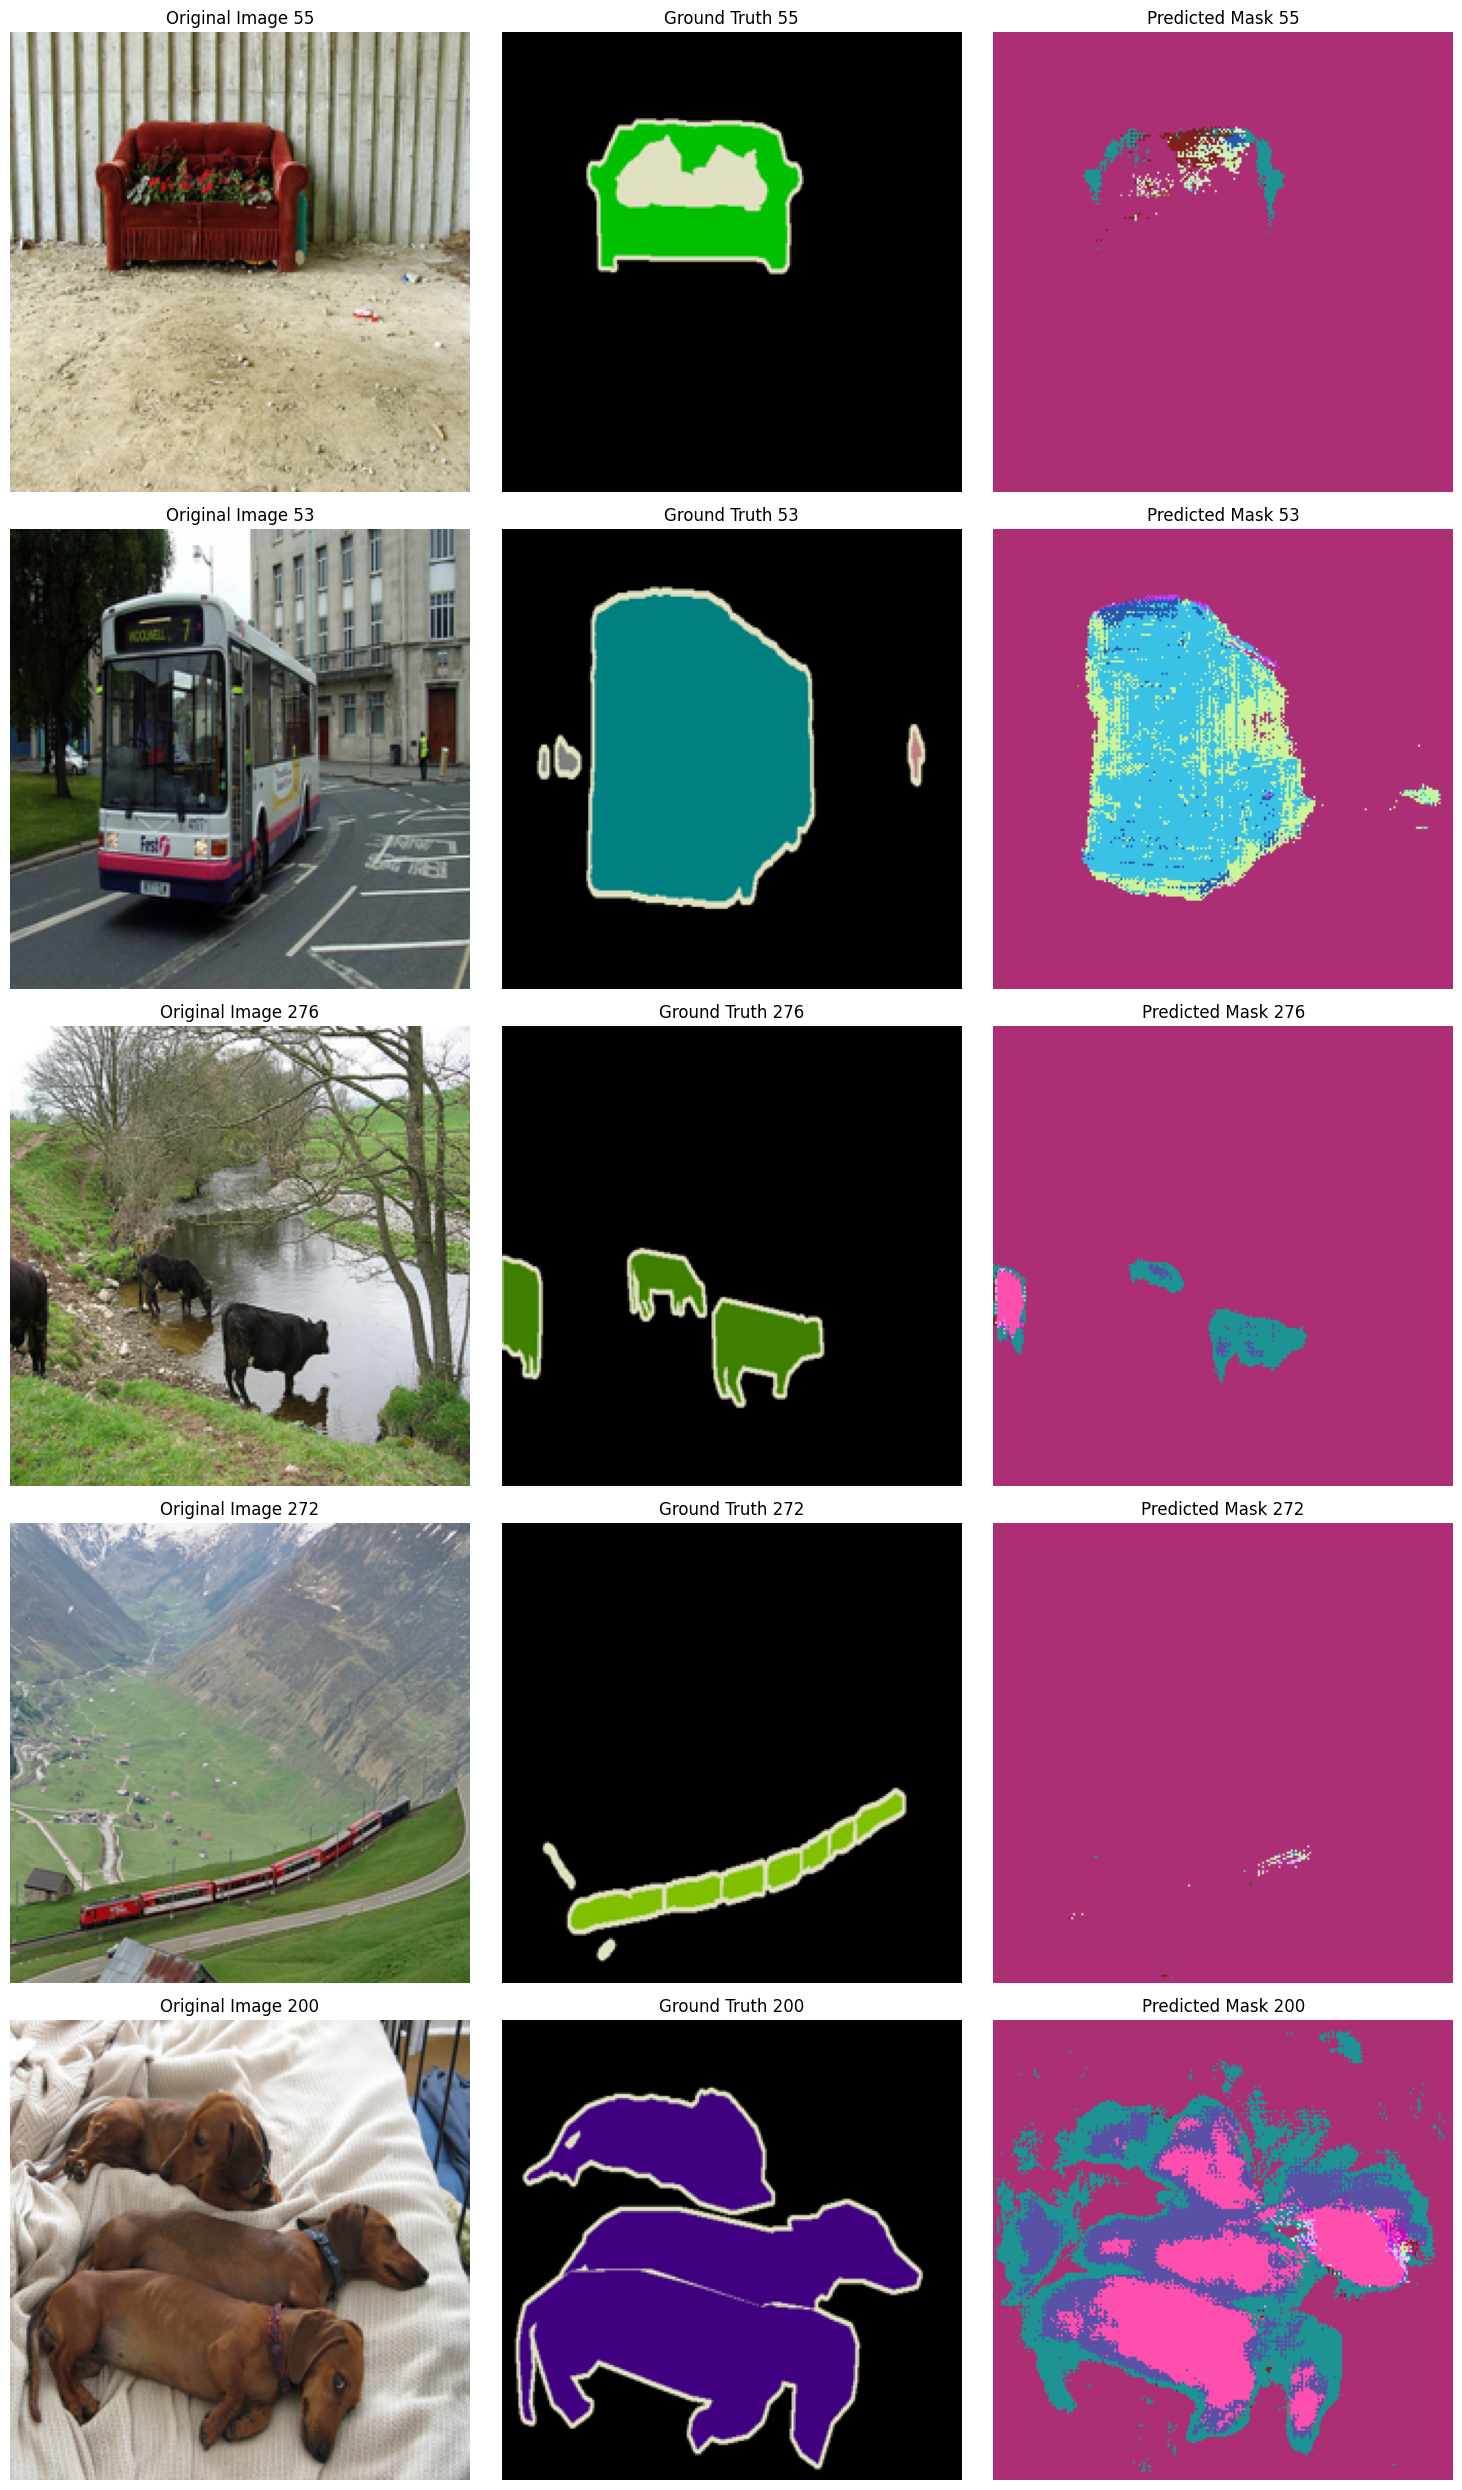


Evaluating best model from optimizer: Adam


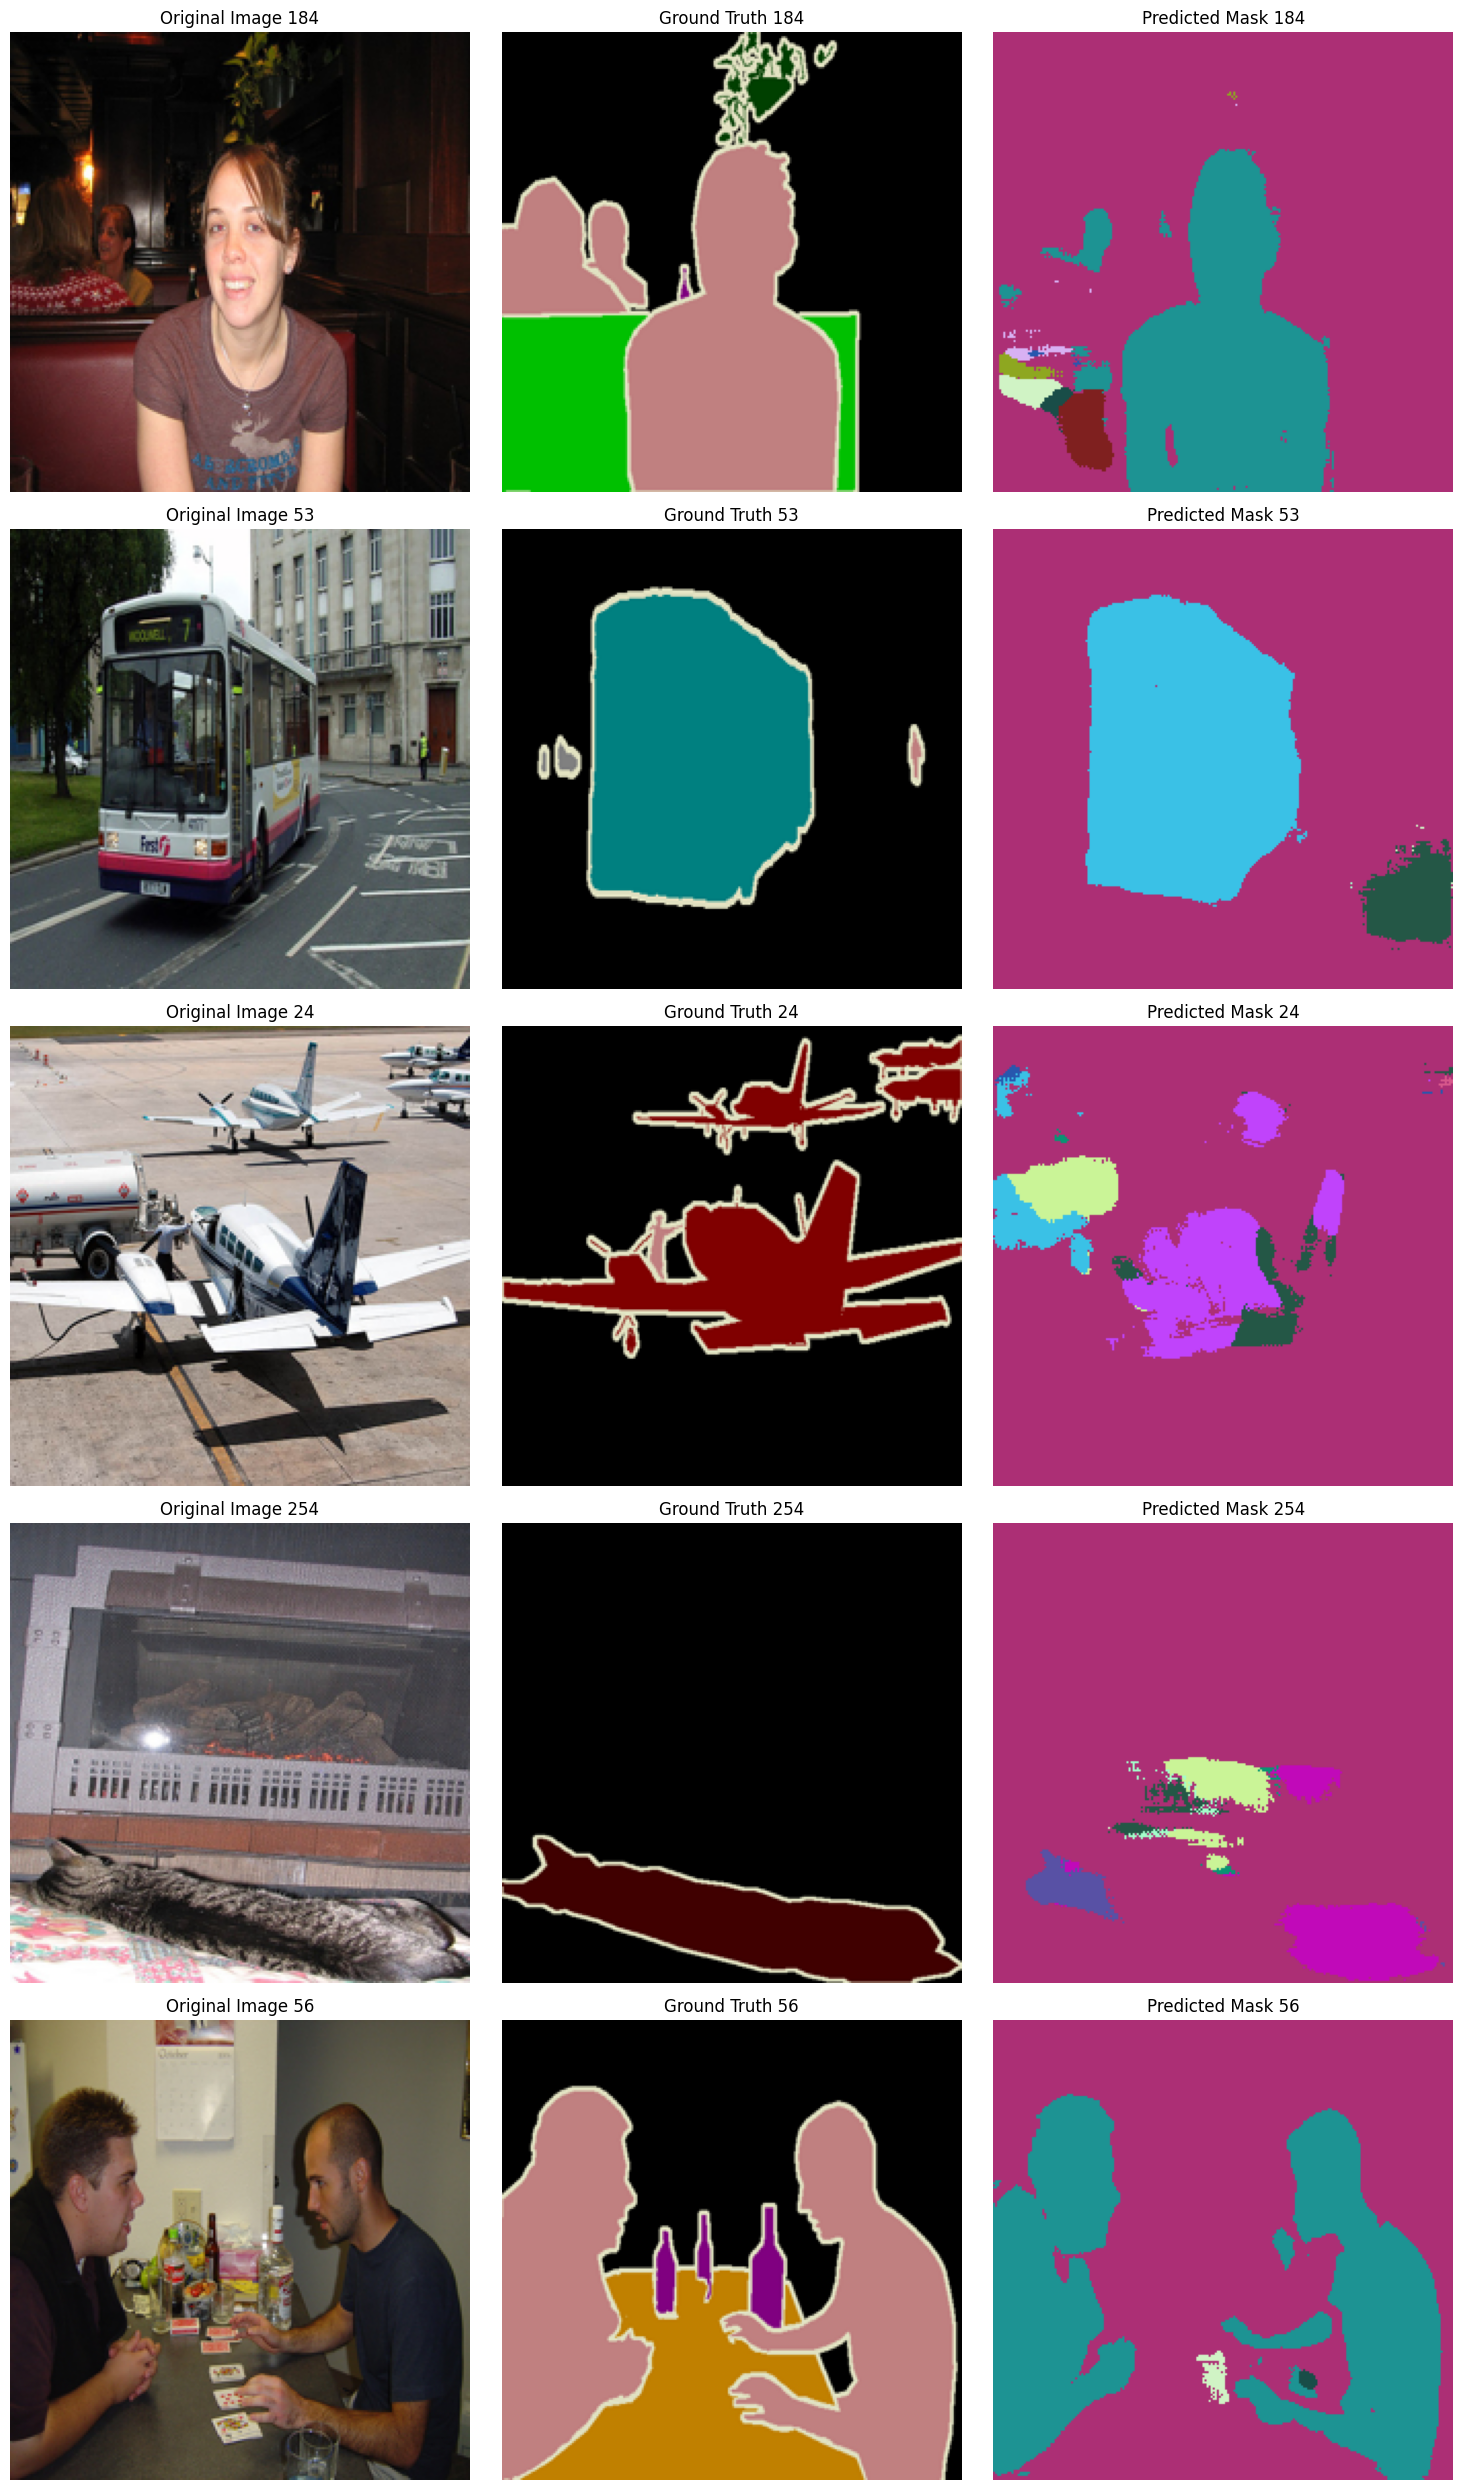


Evaluating best model from optimizer: AdamW


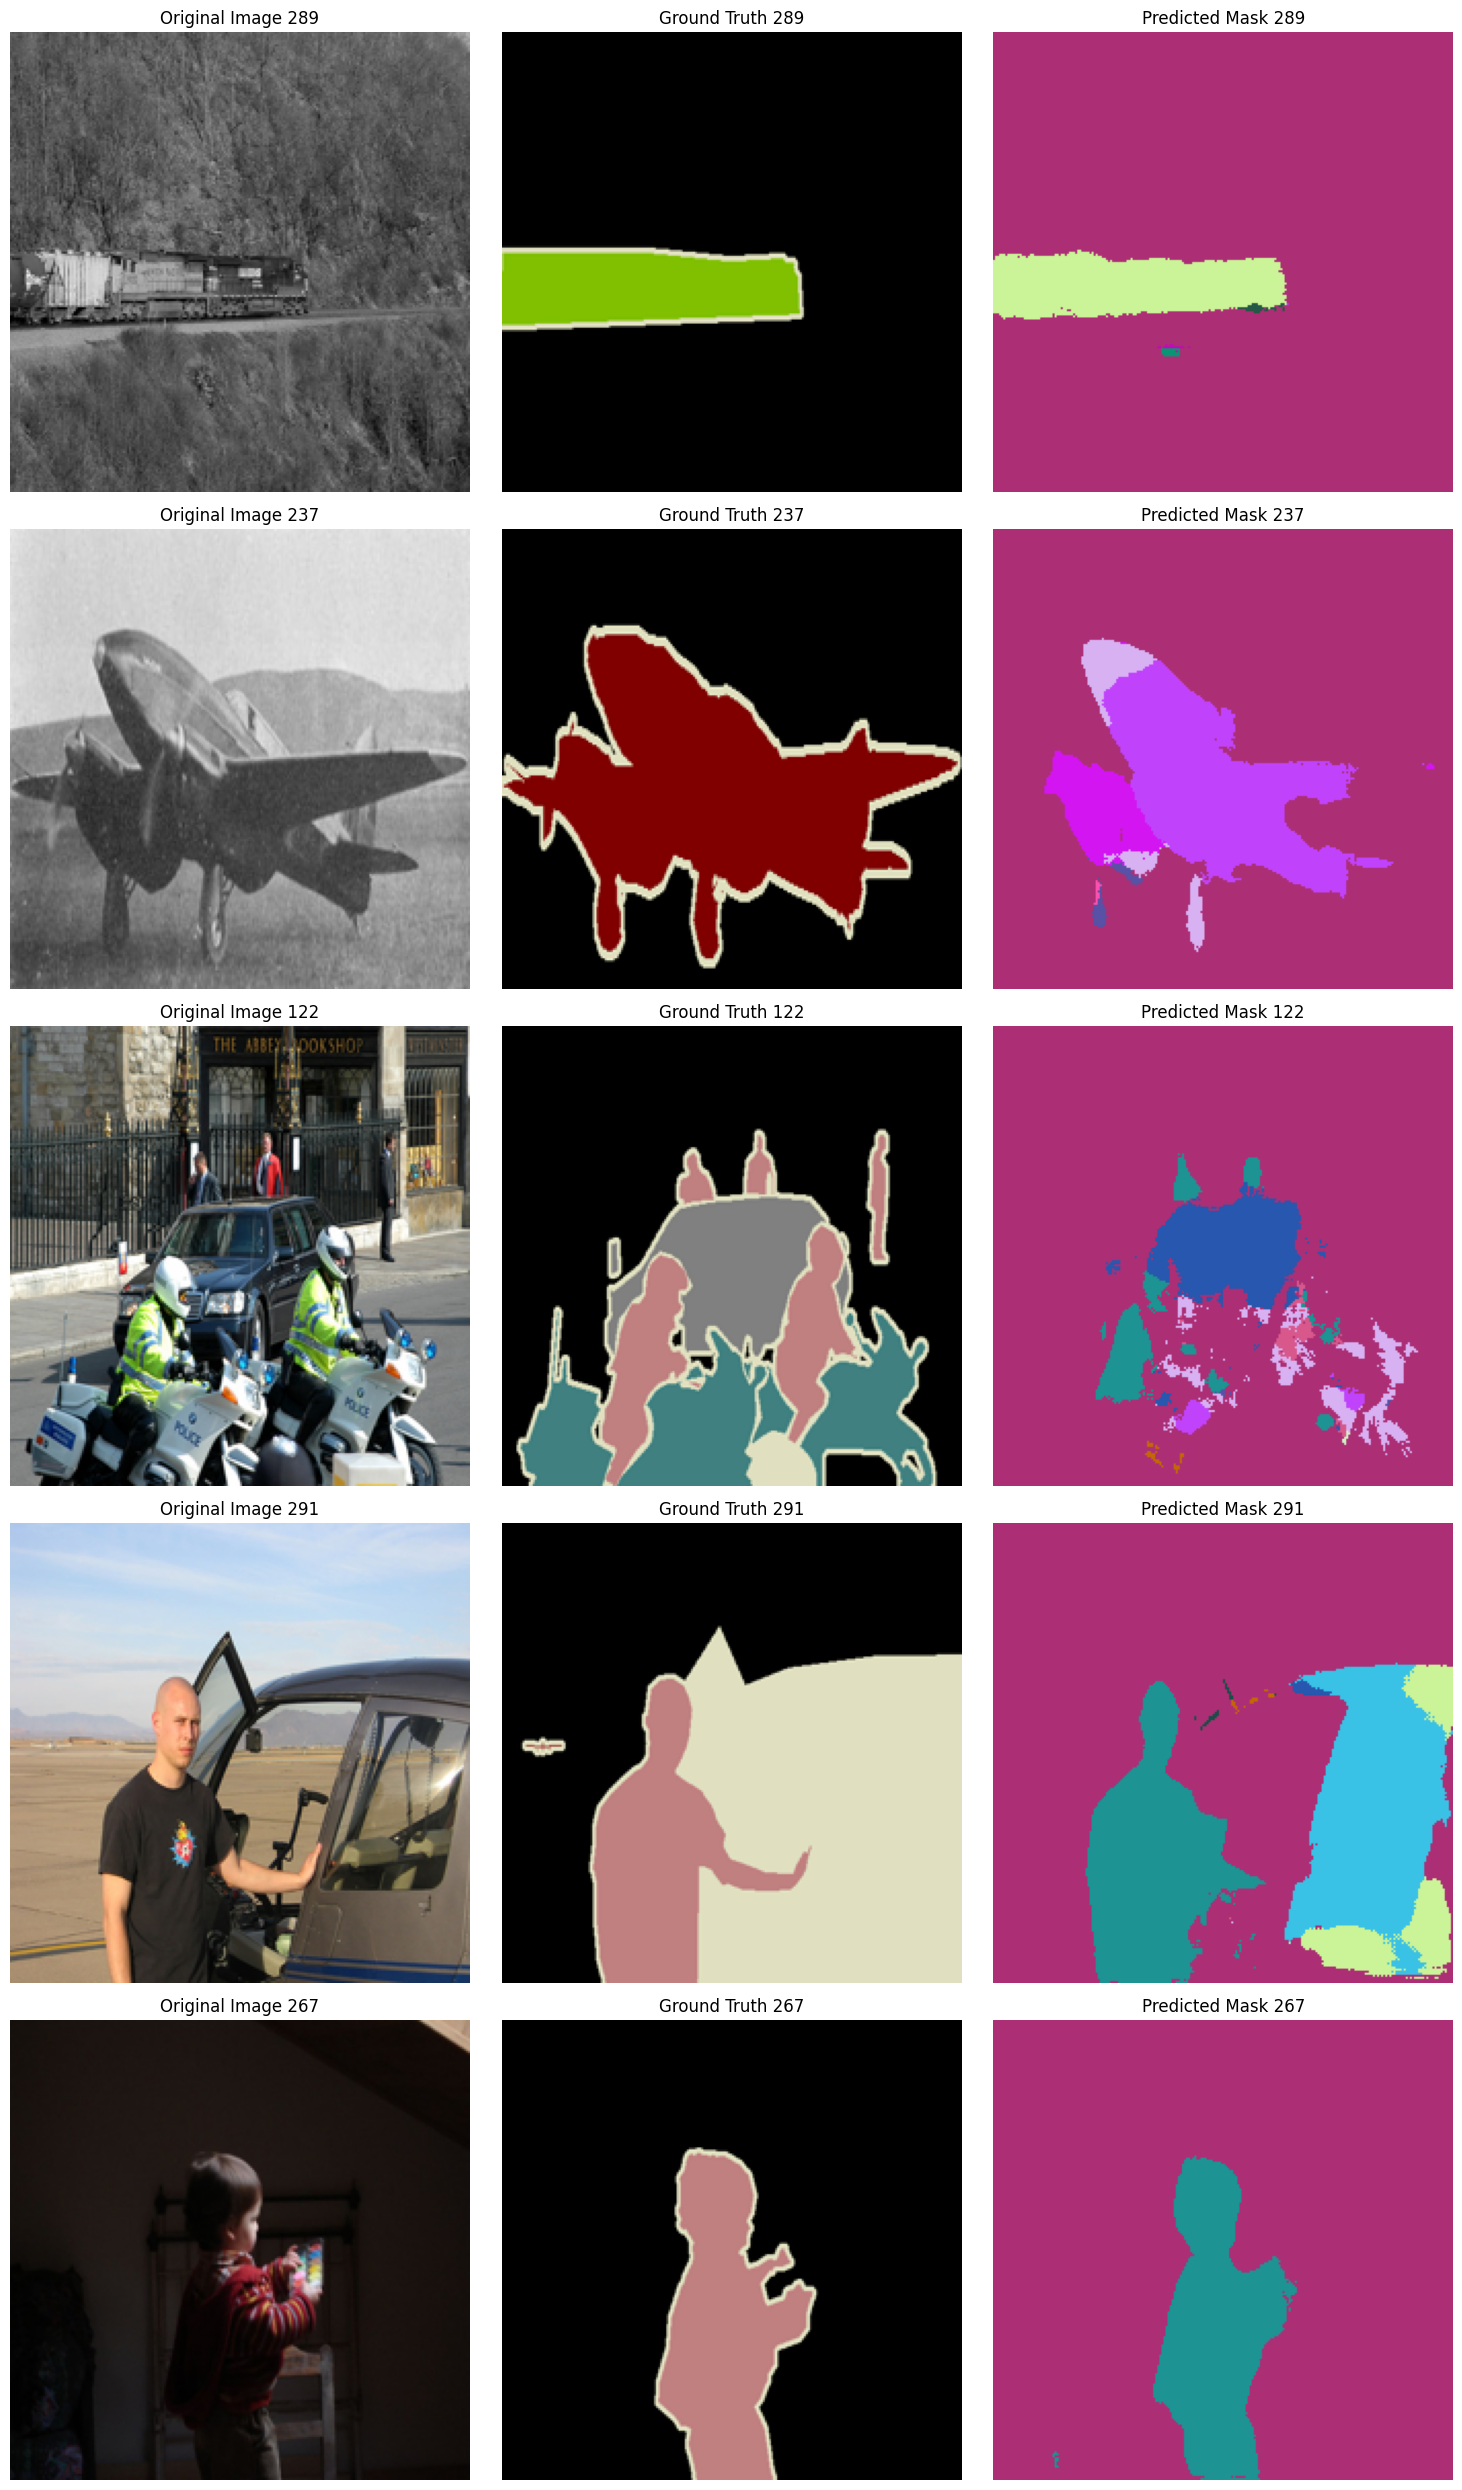

In [19]:
def plot_loss_histories(histories, num_epochs=30):
    plt.figure(figsize=(12, 6))
    for opt_name, history in histories.items():
        plt.plot(range(1, num_epochs + 1), history['train_loss'], label=f"{opt_name} Train Loss")
        plt.plot(range(1, num_epochs + 1), history['val_loss'], label=f"{opt_name} Val Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_histories(all_histories, num_epochs=num_epochs)

def visualize_segmentation(model, dataset, color_map, num_images=5, img_size=224):
    model.eval()
    random_indices = np.random.choice(len(dataset), num_images, replace=False)
    plt.figure(figsize=(15, 5 * num_images))

    for idx, random_idx in enumerate(random_indices):
        img, _ = dataset[random_idx]
        y, _ = dataset.load_imgs(random_idx)
        gt_path = dataset.segmentation_imgs[random_idx]
        gt = Image.open(gt_path).convert("RGB").resize((img_size, img_size))
        gt = np.array(gt)

        img_input = img.unsqueeze(0).to(dataset.device)

        with torch.no_grad():
            y_hat = model(img_input)
        y_hat = torch.argmax(y_hat, dim=1).squeeze().cpu().numpy()
        y_hat_mask = np.zeros((img_size, img_size, 3), dtype=np.uint8)
        for cls, color in color_map.items():
            y_hat_mask[y_hat == cls] = color

        gt_resized = Image.fromarray(gt).resize((img_size, img_size))
        gt_resized = np.array(gt_resized)

        plt.subplot(num_images, 3, 3 * idx + 1)
        plt.imshow(y)
        plt.title(f"Original Image {random_idx+1}")
        plt.axis('off')

        plt.subplot(num_images, 3, 3 * idx + 2)
        plt.imshow(gt_resized)
        plt.title(f"Ground Truth {random_idx+1}")
        plt.axis('off')

        plt.subplot(num_images, 3, 3 * idx + 3)
        plt.imshow(y_hat_mask)
        plt.title(f"Predicted Mask {random_idx+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

for opt_name, best_model_state in best_models.items():
    print(f"\nEvaluating best model from optimizer: {opt_name}\n{'='*40}")
    model = u_net(num_classes=num_classes, device=device).to(device)
    model.load_state_dict(best_model_state)
    model.eval()

    visualize_segmentation(model, test_dataset, color_map, num_images=5, img_size=224)